In [3]:
pip install dash-bootstrap-components

   ---------------------------------------- 0.0/203.7 kB ? eta -:--:--
   ------- ------------------------------- 41.0/203.7 kB 960.0 kB/s eta 0:00:01
   ---------------------- ----------------- 112.6/203.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 203.7/203.7 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Introduction: Import required libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import dash
import dash_bootstrap_components as dbc
from dash import html, dcc, Input, Output


In [6]:
# Load the dataset (ensure the file path is correct)
df = pd.read_csv('data/Students_Social_Media_Addiction.csv')
print(df.head())
print(df.info())


   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score Relationship_Status  Conflicts_Over_Soc

In [7]:
# Clean and standardize categorical variables
df['Gender'] = df['Gender'].str.strip().str.capitalize()
df['Academic_Level'] = df['Academic_Level'].str.strip().str.title()
df['Country'] = df['Country'].str.strip().str.title()
df['Most_Used_Platform'] = df['Most_Used_Platform'].str.strip().str.title()
df['Relationship_Status'] = df['Relationship_Status'].str.strip().str.title()
df['Affects_Academic_Performance'] = df['Affects_Academic_Performance'].str.strip().str.capitalize()

# Handle missing values
critical_cols = [
    'Addicted_Score', 'Academic_Level', 'Gender', 'Age',
    'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night'
]
df = df.dropna(subset=critical_cols)
if 'Mental_Health_Score' in df.columns:
    df['Mental_Health_Score'] = df['Mental_Health_Score'].fillna(df['Mental_Health_Score'].median())
if 'Conflicts_Over_Social_Media' in df.columns:
    df['Conflicts_Over_Social_Media'] = df['Conflicts_Over_Social_Media'].fillna(0)
for col in ['Most_Used_Platform', 'Country', 'Relationship_Status']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])


In [9]:
# Age group categorization
df['Age_Group'] = pd.cut(df['Age'], bins=[15, 18, 21, 24, 30, 100],
                         labels=['16-18', '19-21', '22-24', '25-30', '31+'])

# Normalize Addicted_Score for clustering
scaler = StandardScaler()
df['Addicted_Score_Norm'] = scaler.fit_transform(df[['Addicted_Score']])

# Create categorical addiction levels (tertiles)
df['Addiction_Level'] = pd.qcut(df['Addicted_Score'], q=3, labels=['Low', 'Medium', 'High'])

# Convert 'Affects_Academic_Performance' to numeric for analysis
df['Affects_Academic_Performance_Numeric'] = df['Affects_Academic_Performance'].map({'Yes': 1, 'No': 0})


In [10]:
df.to_csv('data/Processed_Students_Social_Media_Addiction.csv', index=False)
print("Processed data saved.")


Processed data saved.


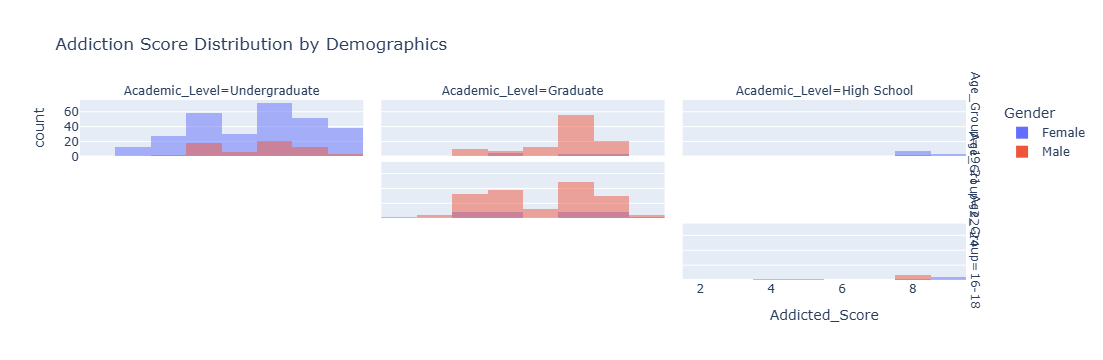

In [11]:
# Interactive bar chart: Addiction Score by demographic
fig = px.histogram(df, x='Addicted_Score', color='Gender', barmode='overlay',
                   facet_row='Age_Group', facet_col='Academic_Level',
                   title='Addiction Score Distribution by Demographics')
fig.show()


C:\Users\rajar\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide



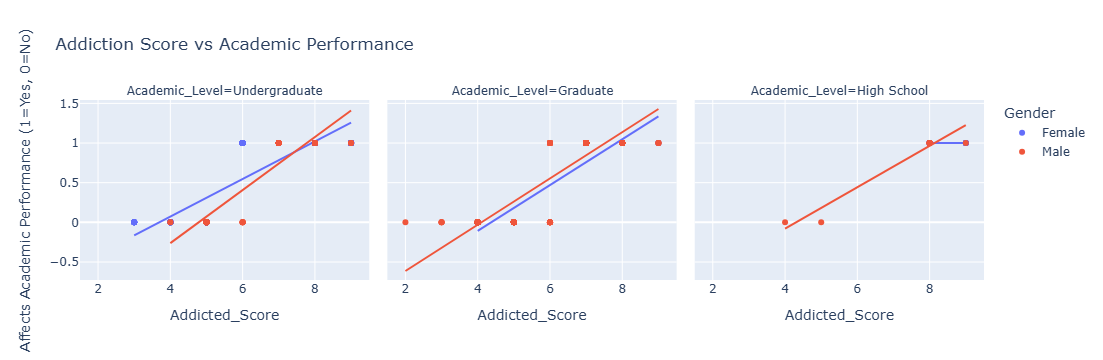

In [12]:
# Scatter plot with regression line
fig = px.scatter(
    df,
    x='Addicted_Score',
    y='Affects_Academic_Performance_Numeric',
    color='Gender',
    facet_col='Academic_Level',
    trendline='ols',
    labels={'Affects_Academic_Performance_Numeric': 'Affects Academic Performance (1=Yes, 0=No)'},
    title='Addiction Score vs Academic Performance'
)
fig.show()


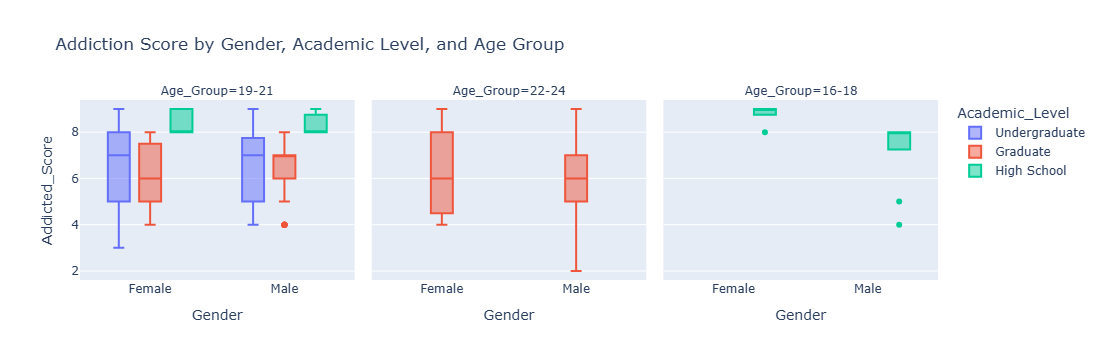

In [13]:
# Box plot: Addiction by Gender, Age Group, Academic Level
fig = px.box(df, x='Gender', y='Addicted_Score', color='Academic_Level',
             facet_col='Age_Group', title='Addiction Score by Gender, Academic Level, and Age Group')
fig.show()


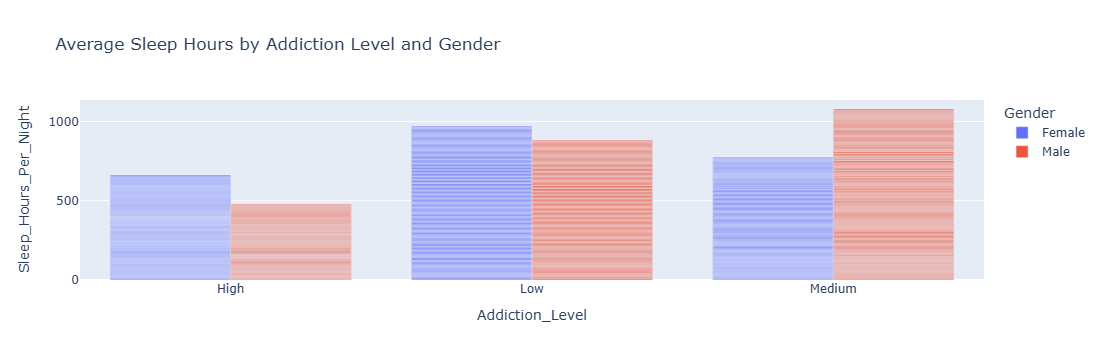

In [14]:
# Sleep hours by addiction level
fig = px.bar(df, x='Addiction_Level', y='Sleep_Hours_Per_Night', color='Gender', barmode='group',
             title='Average Sleep Hours by Addiction Level and Gender')
fig.show()

# (If study hours are available)
if 'Study_Hours' in df.columns:
    fig = px.bar(df, x='Addiction_Level', y='Study_Hours', color='Gender', barmode='group',
                 title='Average Study Hours by Addiction Level and Gender')
    fig.show()


C:\Users\rajar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



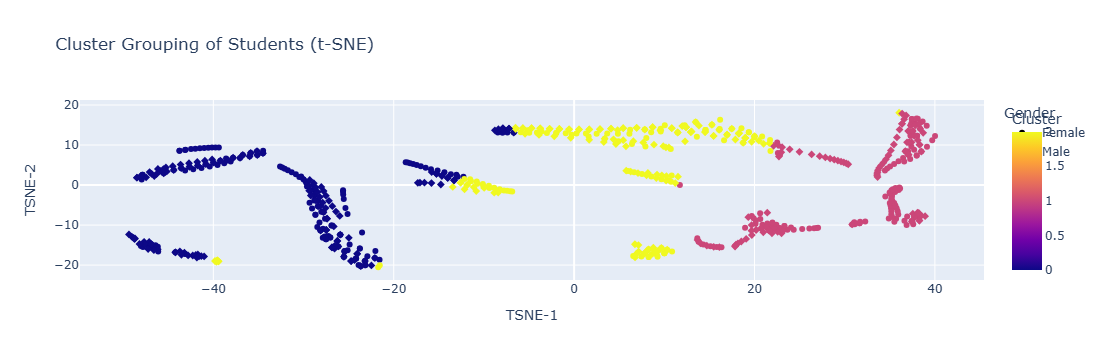

In [15]:
# Prepare features for clustering
features = df[['Addicted_Score', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night']]
features_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_scaled)
df['TSNE-1'] = tsne_results[:, 0]
df['TSNE-2'] = tsne_results[:, 1]

# Clustered scatter plot (t-SNE)
fig = px.scatter(df, x='TSNE-1', y='TSNE-2', color='Cluster', symbol='Gender',
                 title='Cluster Grouping of Students (t-SNE)')
fig.show()


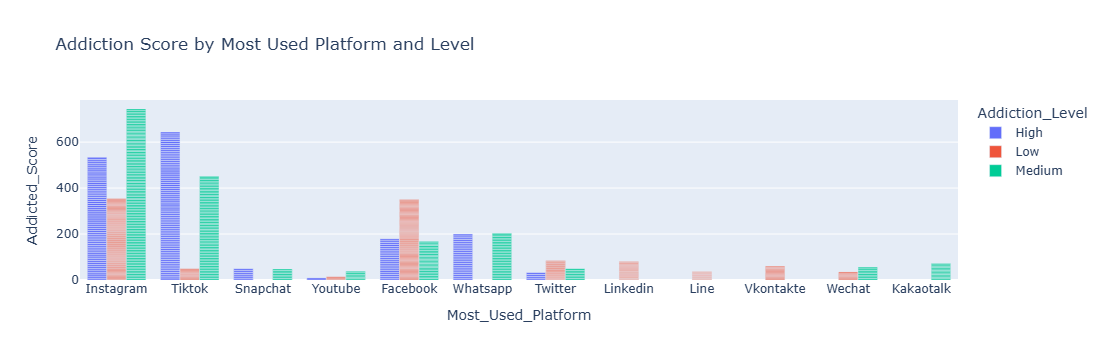

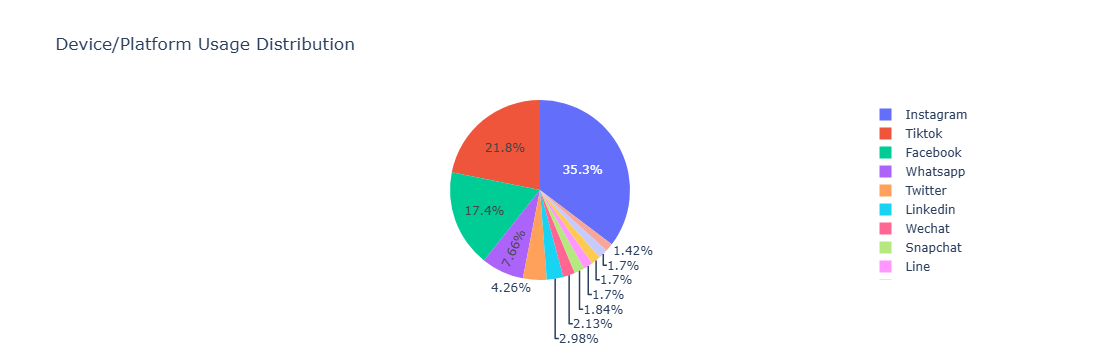

In [16]:
# If device/platform column is available
if 'Most_Used_Platform' in df.columns:
    # Bar chart: Addiction by device/platform
    fig = px.bar(df, x='Most_Used_Platform', y='Addicted_Score', color='Addiction_Level', barmode='group',
                 title='Addiction Score by Most Used Platform and Level')
    fig.show()

    # Pie chart: Device/platform usage
    platform_counts = df['Most_Used_Platform'].value_counts().reset_index()
    platform_counts.columns = ['Most_Used_Platform', 'Count']
    fig = px.pie(platform_counts, names='Most_Used_Platform', values='Count', title='Device/Platform Usage Distribution')
    fig.show()


In [17]:
# If you have a timestamp or hour column, use this code
if 'Usage_Timestamp' in df.columns:
    df['Hour'] = pd.to_datetime(df['Usage_Timestamp'], errors='coerce').dt.hour
    df['DayOfWeek'] = pd.to_datetime(df['Usage_Timestamp'], errors='coerce').dt.dayofweek
    df['WeekPart'] = df['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

    # Line graph: Usage by hour
    hourly_usage = df.groupby('Hour').size().reset_index(name='Usage_Count')
    fig = px.line(hourly_usage, x='Hour', y='Usage_Count', title='Social Media Usage by Hour of Day')
    fig.show()

    # Area chart: Weekday vs Weekend
    hourly_weekpart = df.groupby(['Hour', 'WeekPart']).size().reset_index(name='Usage_Count')
    fig = px.area(hourly_weekpart, x='Hour', y='Usage_Count', color='WeekPart',
                  title='Usage Patterns: Weekday vs Weekend')
    fig.show()

    # Heatmap: Hour vs Sleep Hours
    heatmap_data = df.groupby(['Hour', 'Sleep_Hours_Per_Night']).size().reset_index(name='Count')
    fig = px.density_heatmap(heatmap_data, x='Hour', y='Sleep_Hours_Per_Night', z='Count',
                             title='Usage Hour vs Sleep Hours')
    fig.show()
else:
    print("No temporal usage data available for analysis.")


No temporal usage data available for analysis.
